# Definición del problema

La oferta de casas y departamentos en Santiago de Chile es inmensa, y cada una de ellas posee gran variedad de características que se ajustan a las múltiples necesidades de las personas, tales como el número de habitaciones, baños o estacionamientos, la ubicación de la comuna o la cercanía a estaciones de metros o supermercados. Este variedad de opciones implica una amplia variedad en los precios de los inmuebles afectadas según las características que estos poseen, y esto a su vez, repercute en las decisiones que toman las personas al momento de escoger sus viviendas, en la que se balancea las características y comodidades deseadas según el presupuesto disponible para arrendar o comprar una propiedad.

El presente trabajo nace desde la necesidad del investigador y su pareja en arrendar una vivienda en Santiago, y aprovechando este proceso de mudanza, el planteamiento de la tarea y la misma curiosidad, se desea descubrir cuales son las características que más influyen en el precio de arriendo de un departamento en Santiago, y así ampliar el conocimiento del mercado inmobiliario y, en el mejor de los casos, ayudar al investigador a tomar una decisión más acertada del departamento adecuado para arrendar.

# Descripción del conjunto de datos

El conjunto de datos fue obtenido desde el sitio web Portal Inmobiliario a través del método *web-scraping* programado por el investigador, todo el proceso documentado en [github](https://github.com/smenaaliaga/rent-apartment-system/). Del sitio web se extrajo la totalidad de la oferta de arriendos de departamentos de las comunas de Santiago al día viernes 13 de mayo del 2022.

Las variables obtenidas son :

- titulo : Titulo descriptivo del departamento
- comuna : Comuna donde esta ubicado el departamento
- estacion_cercana : Estación de metro cercana, si es que posee (menos de 2 km)
- distancia_estacion : Distancia (en metros) de la estación más cercana, si es que posee
- dormitorios : Cantidad de dormitorios
- baños : Cantidad de baños
- estacionamientos : Cantidad de estacionamientos
- bodegas : Cantidad de bodegas
- superficie_total : Superficie total del departamento en metros cuadrados (m2)
- superficie_util : Superficie util del departamento en metros cuadrados (m2)
- currency_symbol : Tipo de unidad monetaria cual se paga el precio del departamento (UF o CLP)
- precio : Precio mensual del arriendo del departamento en CLP
- gastos_comunes : Valor del gasto común en CLP
- search_gc : Indicador de donde a obtenido el gasto común, 0 si lo obtuvo directamente o 1 si fue desde la descripción
- descripcion : Descripción del departamento
- ubicacion : Ubicación del departamento
- lat : Latitud del departamento
- long : Longitud del departamento
- url : URL original de donde se obtuvo la data del departamento

La extracción de los datos consideró un preprocesamiento de estos, eliminando texto y cáracteres especial de algunas variables numericas tales como el precio, los m2 de la superficie, entre otros. También se optó por tratar la extracción de la descripciones de los departamentos, aplicando *lowercase* al texto, normalización a ASCII y eliminación de cáracteres especiales. Por otro lado, no todos los departamentos tenían el valor de su gasto común en la sección habilitada por el sitio, y muchas veces los oferentes del departamento optaban por ingresar el valor del gasto común en la descripción, por lo que, se automatizó su obtención desde la descripción cuando esta no se encontraba en la sección de gastos comunes. Además, se obtuvieron las latitudes y longitudes de todas las estaciones de metro (tambén a través de *web-scraping*), y teniendo la latitud y longitud del propio departamiento, se obtuvo la estación del metro y la distancia más cercana al departamento de la estación, haciendo uso de la formula de Haversine.

Además, la exploración de los datos se observaron algunos datos atípicos, con precios desorbitantes a la billetera "común" o cantidades de baños o dormitorios que rozan la innecesidad propia de una familia convencional, por lo que simplemente se eliminan del dataset. 

Las columnas "titulo", "currency_symbol", "search_gc", "ubicación" y "url" son únicas por departamento o no entregan información adicional para la clasificación, por lo que no fueron consideradas dentro de la investigación. Además, se excluye de la investigación la variable "descripcion" aún sabiendo que en ella se podría obtener información relevante, esta variable será considerada para futuros trabajos.

# Carga y preprocesamiento de datos

In [1]:
import warnings; warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
# Carga
df = pd.read_csv('data/departamentos.csv')
df.shape

(5968, 19)

Luego de realizar el *scraping* de toda la oferta de arriendo de departamentos de las comunas en Santiago al día 13 de mayo 2022, se obtuvo un total de 5968 registros.

## ETL

In [4]:
# Conversión del tipo de dato
df['precio'] = df['precio'].astype(float)
df['gastos_comunes'] = df['gastos_comunes'].astype(float)
df['superficie_total'] = df['superficie_total'].replace(to_replace=",", value='.', regex=True)
df['superficie_total'] = df['superficie_total'].astype(float)
df['superficie_util'] = df['superficie_util'].replace(to_replace=",", value='.', regex=True)
df['superficie_util'] = df['superficie_util'].astype(float)
# Filtro de columnas no consideradas
df = df[df.columns[~df.columns.isin(['titulo','currency_symbol','search_gc','descripcion','direccion','ubicacion','url'])]]
# Se filtran columna de estación de metro cercanas, dado que se obtiene de otra manera
df = df[df.columns[~df.columns.isin(['estacion_cercana','distancia_estacion'])]]
# Si no hay valor de gasto comun, se asume que es 0
df['gastos_comunes'] = df['gastos_comunes'].fillna(0)
# Si no hay valor en estacionamientos y bodegas, se asume que es 0
df['estacionamientos'] = df['estacionamientos'].fillna(0)
df['bodegas'] = df['bodegas'].fillna(0)
# Agregar precio total
df['precio_total'] = df['precio'] + df['gastos_comunes']

Si bien el metro cercano y su distancia a los departamentos son datos que aportaba Portal Inmobiliario, estos datos solo estaban presentes si el departamento tenía un metro cercano a menos de 2km, y dado que se considera un dato relevante para la investigación, se optó por cálcular estos valores para todos los departamentos. Para ello, se obtuvieron las latitudes y longitudes de todas las estaciones de metros a través del método *web-scraping*, y con las latitudes y longitudes de cada departamento que fueron obtenidos en el primer *scraping*, se calculó las distancias (usando Haversine) entre estaciones de metro y se almacenó aquella estación (y su distancia) que sea más cercana al departamento.

In [5]:
# Obtención del estaciones de metros más cercanas a los departamentos y sus distancias en metros
import sys
sys.path.append('../utils/')
from estaciones_cercanas import estaciones_cercanas
# La función añade al data frame la columna con el metro mas cercano y su distancia (metros)
df = estaciones_cercanas(df)

# Análisis Exploratorio de Datos (AED)

In [6]:
df.head()

,comuna,dormitorios,baños,estacionamientos,bodegas,superficie_total,superficie_util,precio,gastos_comunes,lat,long,precio_total,distancia_estacion,estacion_cercana
0,Cerrillos,3.0,1.0,1.0,0.0,80.0,80.0,450000.0,4000.0,-33.505603,-70.734114,454000.0,1980.421945,Lo Errázuriz
1,Cerrillos,3.0,2.0,1.0,0.0,66.0,66.0,450000.0,55000.0,-33.507878,-70.724669,505000.0,1940.623326,Lo Errázuriz
2,Cerrillos,3.0,2.0,0.0,0.0,90.0,80.0,580000.0,120000.0,-33.503846,-70.704701,700000.0,2241.346045,Lo Errázuriz
3,Cerrillos,3.0,1.0,0.0,0.0,66.0,66.0,380000.0,5000.0,-33.506189,-70.730548,385000.0,1887.067564,Lo Errázuriz
4,Cerrillos,3.0,2.0,1.0,0.0,90.0,90.0,600000.0,80000.0,-33.500000,-70.733300,680000.0,1436.677200,Lo Errázuriz


### Análisis de valores perdidos NaN

In [7]:
# Revisión de NaN
pd.isna(df).sum()

comuna                  0
dormitorios            35
baños                  29
estacionamientos        0
bodegas                 0
superficie_total       89
superficie_util       155
precio                  0
gastos_comunes          0
lat                     0
long                    0
precio_total            0
distancia_estacion      0
estacion_cercana        0
dtype: int64

Se observar valores perdidos en las variables dormitorios, baños, superficie_total y útil, no es posible asumir facilmente un valor para estas variables, además representan una cantidad marginal del subconjunto, por lo que se eliminan del dataset aquellos registros que no posean datos en dormitorios, baños y sperficie_total. No se eliminan las de superficie_util, dado que la información de esta esta contenida en superficie_total, y hay menos perdidas si se trabaja con superficie_total.

In [8]:
df = df[df['dormitorios'].notna()]
df = df[df['baños'].notna()]
df = df[df['superficie_total'].notna()]
pd.isna(df).sum()

comuna                 0
dormitorios            0
baños                  0
estacionamientos       0
bodegas                0
superficie_total       0
superficie_util       67
precio                 0
gastos_comunes         0
lat                    0
long                   0
precio_total           0
distancia_estacion     0
estacion_cercana       0
dtype: int64

Se eliminan las columnas que contienen información altamente redundante (colineales) que estan ya presentes en otras variables, tales como:
- superficie_util: información presente en superficie_total
- precio y gastos_comunes : información presente en precio_total

In [9]:
# Se eliminan variables que contienen información altamente redundante en otras variable
df = df[df.columns[~df.columns.isin(['superficie_util','precio','gastos_comunes'])]]

In [10]:
df.head()

,comuna,dormitorios,baños,estacionamientos,bodegas,superficie_total,lat,long,precio_total,distancia_estacion,estacion_cercana
0,Cerrillos,3.0,1.0,1.0,0.0,80.0,-33.505603,-70.734114,454000.0,1980.421945,Lo Errázuriz
1,Cerrillos,3.0,2.0,1.0,0.0,66.0,-33.507878,-70.724669,505000.0,1940.623326,Lo Errázuriz
2,Cerrillos,3.0,2.0,0.0,0.0,90.0,-33.503846,-70.704701,700000.0,2241.346045,Lo Errázuriz
3,Cerrillos,3.0,1.0,0.0,0.0,66.0,-33.506189,-70.730548,385000.0,1887.067564,Lo Errázuriz
4,Cerrillos,3.0,2.0,1.0,0.0,90.0,-33.500000,-70.733300,680000.0,1436.677200,Lo Errázuriz


### Resumen de la variable Y de respuesta: precio_total

In [11]:
df[['precio_total']].describe()

,precio_total
count,5.824000e+03
mean,2.793388e+06
std,2.701794e+07
min,1.850000e+05
25%,4.470000e+05
50%,6.659545e+05
75%,1.497398e+06
max,1.051847e+09


Se observa un precio total máximo muy desorbitante respecto al 75% del conjunto.

Se opta por trabajar con precios totales menores a $2.000.000$ CLP, que representa solo $500.000$ CLP más del tercer cuartil ($75\%$) de los precios.

In [12]:
df = df.loc[(df['precio_total'] <= 2000000)]
df[['precio_total']].describe()

,precio_total
count,5.017000e+03
mean,7.821341e+05
std,4.666356e+05
min,1.850000e+05
25%,4.250000e+05
50%,5.800000e+05
75%,1.030000e+06
max,2.000000e+06


Text(0.5, 1.0, 'Histograma de precio total en CLP')

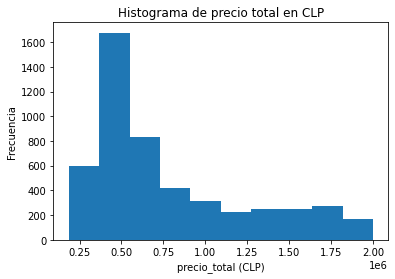

In [13]:
plt.hist(df["precio_total"])
plt.xlabel("precio_total (CLP)")
plt.ylabel("Frecuencia")
plt.title("Histograma de precio total en CLP")

### Resumen de variables predictora cuantitativas

In [14]:
# Resumén estadístico de variables númericas
df[df.columns[~df.columns.isin(['precio_total','lat','long'])]].describe()

,dormitorios,baños,estacionamientos,bodegas,superficie_total,distancia_estacion
count,5017.000000,5017.000000,5017.000000,5017.000000,5017.000000,5.017000e+03
mean,2.008372,1.714969,0.826590,0.430735,134.675260,4.131880e+03
std,0.960924,0.825047,2.990053,2.815080,2420.225614,2.188286e+05
min,1.000000,1.000000,0.000000,0.000000,1.000000,5.628300e+00
25%,1.000000,1.000000,0.000000,0.000000,40.000000,3.224206e+02
50%,2.000000,2.000000,1.000000,0.000000,57.000000,5.217782e+02
75%,3.000000,2.000000,1.000000,1.000000,94.000000,8.794682e+02
max,22.000000,20.000000,140.000000,180.000000,160020.000000,1.549002e+07


Nuevamente se observan casos atípicos en todas las columnas, por lo que se decide filtrar considerando valores razonables un poco mayores al 75% de los datos.

In [15]:
# Tratamiento de los casos atípicos
df = df.loc[(df['dormitorios'] <= 5)]
df = df.loc[(df['baños'] <= 5)]
df = df.loc[(df['estacionamientos'] <= 3)]
df = df.loc[(df['bodegas'] <= 3)]
df = df.loc[(df['superficie_total'] <= 300)]
df = df.loc[(df['distancia_estacion'] <= 8000)]
df.shape

(4958, 11)

Luego de aplicar todos los filtros, se obtuvo un dataset total de 4968 departamentos, reduciendo aproximandamente un $20\%$ del conjunto original.

In [16]:
df[df.columns[~df.columns.isin(['precio_total','lat','long'])]].describe()

,dormitorios,baños,estacionamientos,bodegas,superficie_total,distancia_estacion
count,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000,4958.000000
mean,1.997378,1.704720,0.723477,0.376160,73.101666,793.637068
std,0.902439,0.768519,0.701865,0.493546,44.698207,840.650187
min,1.000000,1.000000,0.000000,0.000000,1.000000,5.628300
25%,1.000000,1.000000,0.000000,0.000000,40.000000,322.344898
50%,2.000000,2.000000,1.000000,0.000000,56.000000,518.046990
75%,3.000000,2.000000,1.000000,1.000000,92.000000,874.582846
max,5.000000,5.000000,3.000000,3.000000,300.000000,5737.590614


Text(0.5, 0.98, 'Diagramas de barras de dormitorios, baños, estacionamientos y bodegas')

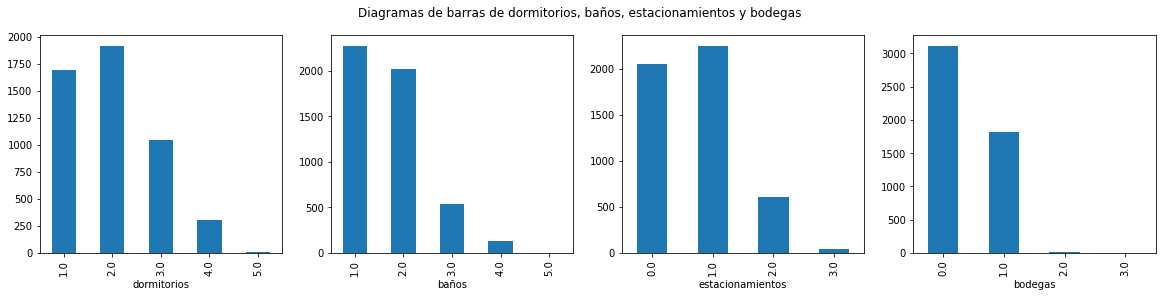

In [17]:
figure, axs = plt.subplots(1,4, figsize=(20,4))
df.groupby(['dormitorios'])['dormitorios'].count().plot(kind='bar', ax=axs[0])
df.groupby(['baños'])['baños'].count().plot(kind='bar', ax=axs[1])
df.groupby(['estacionamientos'])['estacionamientos'].count().plot(kind='bar', ax=axs[2])
df.groupby(['bodegas'])['bodegas'].count().plot(kind='bar', ax=axs[3])
plt.suptitle("Diagramas de barras de dormitorios, baños, estacionamientos y bodegas")

Text(0.5, 1.0, 'Histograma de distancias a estaciones más cercanas (m)')

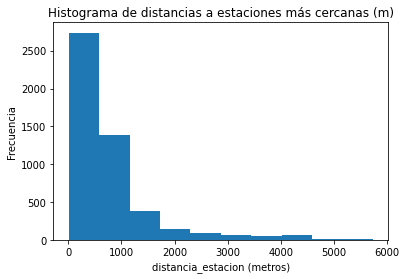

In [18]:
plt.hist(df["distancia_estacion"])
plt.xlabel("distancia_estacion (metros)")
plt.ylabel("Frecuencia")
plt.title("Histograma de distancias a estaciones más cercanas (m)")

Text(0.5, 1.0, 'Histograma de superficie total (m2)')

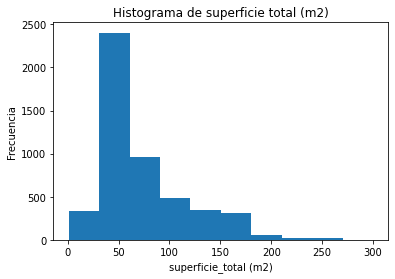

In [19]:
plt.hist(df["superficie_total"])
plt.xlabel("superficie_total (m2)")
plt.ylabel("Frecuencia")
plt.title("Histograma de superficie total (m2)")

### Resumen de variables predictoras categoricas

In [20]:
# Resumén estadístico de variables categoricas
df.describe(include = ['O'])

,comuna,estacion_cercana
count,4958,4958
unique,31,113
top,Santiago,Manquehue
freq,1319,339


In [21]:
# Resumen por comuna
df.groupby(['comuna'])['comuna'].count().sort_values(ascending=False).head(10)

comuna
Santiago         1319
Las Condes        951
Providencia       458
San Miguel        447
Ñuñoa             408
Vitacura          376
La Florida        187
La Cisterna       159
Macul             141
Independencia     139
Name: comuna, dtype: int64

Las comunas con la oferta más grande en arriendo de departamentos es Santiago representando un $22.1\%$ de la muestra, seguido de Las Condes con un $16\%$ y Providencia con un $7.7\%$

In [22]:
# Resumen por estción cercana, 10 primeras (de 45)
df.groupby(['estacion_cercana'])['estacion_cercana'].count().sort_values(ascending=False).head(10)

estacion_cercana
Manquehue                 339
Escuela Militar           270
Los Dominicos             214
San Miguel                197
Santa Ana                 168
Parque Almagro            163
Santa Lucía               157
Alcántara                 147
Hernando de Magallanes    132
Inés de Suárez            125
Name: estacion_cercana, dtype: int64

Si bien es la comuna de Santiago la que posee la mayor oferta de arriendo de departamentos, son las estaciones de metro de la comuna de Las Condes (linea 1) la que poseen mayor cantidad de departamentos cercanos: Manquehue, Escuela Militar y Los Dominicos 

### Mapa de los departamentos

Text(0.5, 1.0, 'Scatterplot de lat y long de departamentos (mapa de calor de precios)')

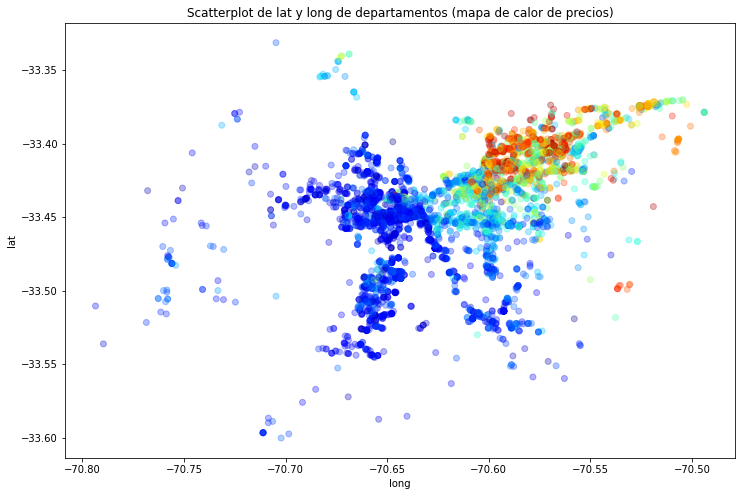

In [23]:
plt.figure(figsize=(12,8)) 
plt.scatter(df['long'], df['lat'],
c = df['precio_total'], cmap=plt.get_cmap("jet"), alpha = 0.3)
plt.ylabel('lat')
plt.xlabel('long')
plt.title("Scatterplot de lat y long de departamentos (mapa de calor de precios)")

Text(0.5, 1.0, 'Mapa de ofertas de arriendo de departamento en Santiago de Chile, Abril 2022')

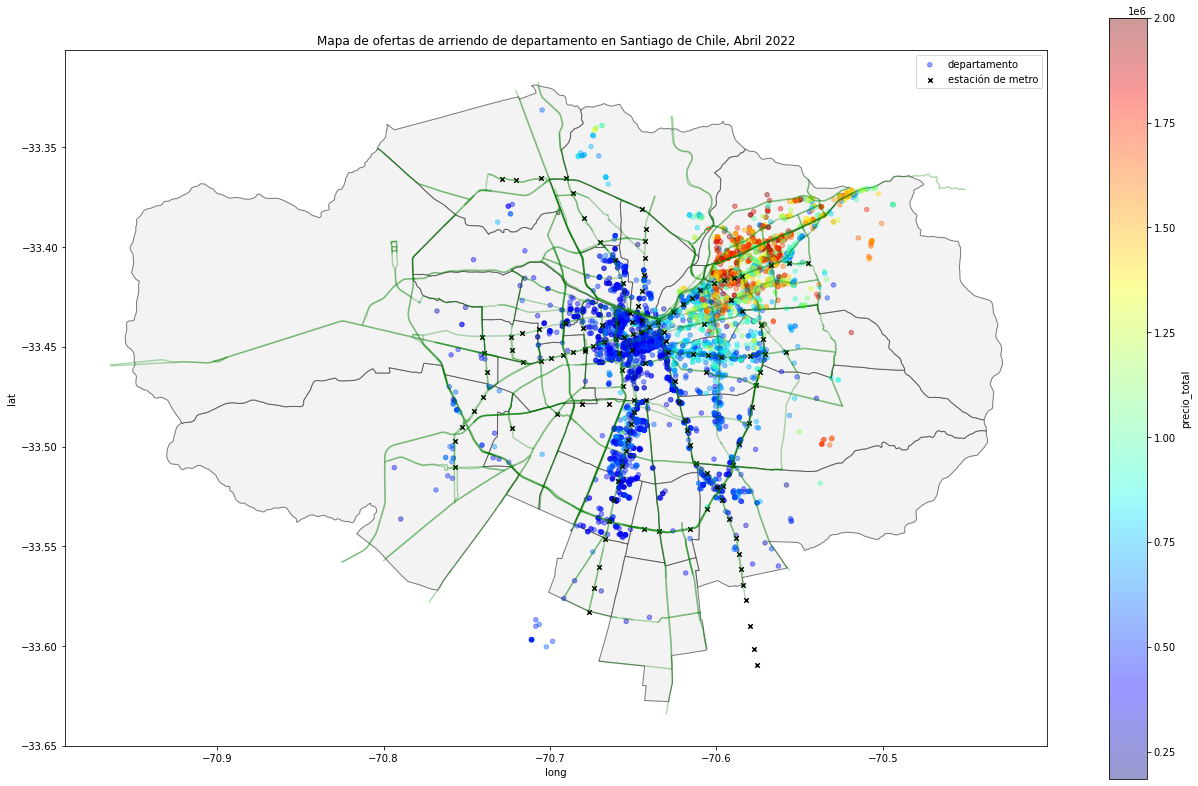

In [24]:
# Santiago
sf_path = "data/shp/comunas/comunas.shp"
sf = gpd.read_file(sf_path, encoding='utf-8')
stgo_sf = sf[(sf.Provincia == 'Santiago') & (sf.Comuna != 'Lo Barnechea')]
stgo_shape = stgo_sf.to_crs({'init': 'epsg:4326'})
# Principales avenidas
roads_path = "data/shp/rutas/gis_osm_roads_free_1.shp"
roads = gpd.read_file(roads_path, encoding='utf-8')
roads = gpd.sjoin(roads, stgo_shape, op='intersects')
main_roads = roads[(roads.fclass == 'primary') | (roads.fclass == 'motorway')]
# Estaciones Metro Santiago
metro = pd.read_csv('../scraping/output/estaciones.csv')
# Plot
ax = stgo_shape.plot(figsize=(22,14), color='#EFEFEF', edgecolor='#444444', alpha = 0.7)
main_roads.plot(ax=ax, color='green', markersize=0.1, alpha = 0.3)
df.plot(x = 'long', y = 'lat', kind = 'scatter', c = 'precio_total', cmap=plt.get_cmap("jet"), label = 'departamento', colorbar = True, ax=ax, alpha = 0.4)
metro.plot(ax=ax, x = 'long', y = 'lat', kind = 'scatter', marker = 'x', color = 'black', label = 'estación de metro')
plt.title("Mapa de ofertas de arriendo de departamento en Santiago de Chile, Abril 2022")

El mapa anterior muestra las divisiones de comunas de Santiago, las lineas verdes representa las principales avenidas de la ciudad, las cruces negras representa las estaciones de metros de Santiago y los circulos representa cada uno de los departamentos ofrecidos, además cada departamento se asocia al mapa de calor del precio total del departamento, que va desde los colores morados los precios más económicos hasta los colores rojos los más caros ofrecidos.

Se puede observar una alta densidad de departamentos en las comuna de Santiago, también se observa como la densidad de la oferta se conglomera alrededor de las princiaples avenidas y cercana a estaciones de metro, principalmente en la zona sur. Además, se observa que los precios más altos de la oferta se conglomeran en el sector oriente de Santiago.

# Modelos para la Regresión

Se ajustan y se mide el rendimiento de los modelos de Regresión Lineal, Ridge, Lasso y Elastic Net para la predicción del precio total (precio + gasto común) del arriendo de departamentos en Santiago, y a su vez, entender como influyen las variables predictoras en el precio de los departamentos. Para ello, se presentan a continuación la clasificación de las variables en el uso de los modelos:

#### Variable Y de respuesta (cuantitativa continua) :

- precio_total

#### Variables X predictoras :

Variables categoricas

- comuna
- estacion_cercana

Variables cuatitativas discretas

- dormitorios
- baños
- estacionamientos
- bodegas

Variables cuantitativas continuas

- lat
- long
- distancia_estacion
- superficie_total

In [25]:
X = df.drop(['precio_total'],axis=1)
y = df[['precio_total']]

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### Arreglo de predicciones

Se crea un arreglo vacio de predicciones para diferentes ajuste de modelos con la finalidad de evaluar dichos modelos en un diagrama de Taylor

In [28]:
# Arreglo de predicciones para diferentes modelos
y_hats = []

### Transformación de los datos

Para trabajar con modelos de Regresión Lineal, todas las variables deben ser cuatitativas, para ello las variables categoricas comuna y estacion_cercana se codifican como variables *dummy*, además, se estandarizan las variables para que estan queden en una misma escala

In [29]:
# Variables categoricas
num_vars = ['dormitorios','baños','estacionamientos','bodegas','lat','long','distancia_estacion','superficie_total']
# Variables numericas
cat_vars = ['comuna','estacion_cercana']
# Transformación
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), num_vars),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_vars)
])

## Regresión Lineal

In [30]:
from sklearn.linear_model import LinearRegression

El modelo de regresión lineal es un método que intenta ajustar un valor objetivo (a predecir) con valores independientes (predictores) a partir de una combinación lineal, representando de la siguiente manera

$y = \beta_0 + \beta_1 x_1 + ... + \beta_p x_p$

Donde $\beta_0$ es el intercepto y cada $\beta_p$ es el coeficiente de regresión de cada variable

El método de ajuste de los coeficientes $\beta$ más utilizado es el de mínimos cuadrados, y en su forma más simple intenta mínimizar la suma cuadrada de los residuos 

$argmin_{\beta} ||X \beta - y||^2$

#### Ajuste del modelo

Se realiza un Pipeline de las regresión y el preprocesamiento de los datos

In [31]:
# Regla de ajuste
reg = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regression', LinearRegression())
])

Se ajusta el modelo a partir de los datos de entrenamiento

In [32]:
# Ajuste del modelo
reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['dormitorios', 'baños',
                                                   'estacionamientos',
                                                   'bodegas', 'lat', 'long',
                                                   'distancia_estacion',
                                                   'superficie_total']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['comuna',
                                                   'estacion_cercana'])])),
                ('regression', LinearRegression())])

#### Validaciones

Se calcula el R2 del modelo ajustado a partir del conjunto de testing

In [33]:
# Cálculo de R2
r2 = reg.score(X_test, y_test)
r2

0.9015931764423812

El modelo aporta un un excelente R2

In [34]:
# Validación Cruzada
scores = cross_val_score(reg, X, y, cv=5)
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard deviation:", scores.std())

Scores: [0.79941169 0.803546   0.787318   0.74417404 0.91752601]
Mean: 0.810395148163044
Standard deviation: 0.05755407722265915


Se observa que los R2 cálculados a partir de la validación cruzada con CV = 5 también aprtan un buen desempeño en promedio

In [35]:
# Predicción a partir del conjunto de testeo
y_pred = reg.predict(X_test)
# Guardamos la predicción
y_hats.append(y_pred.ravel())

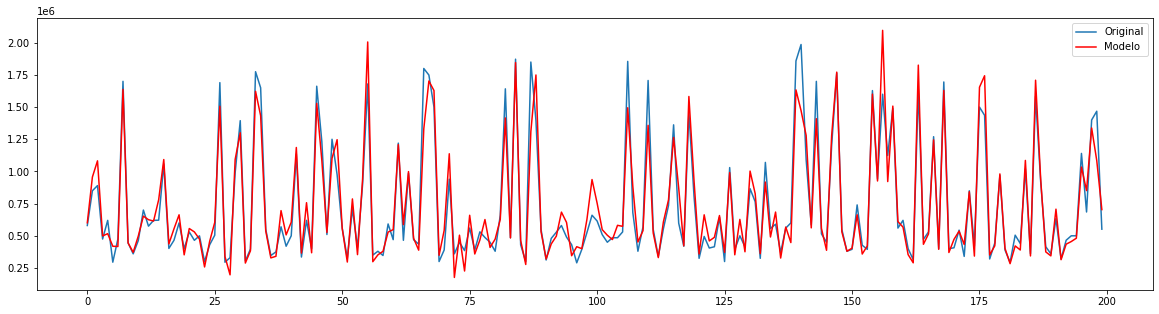

In [36]:
plt.subplots(figsize=(20,5))
plt.plot(y_test.values[:200], label="Original")
plt.plot(y_pred[:200], 'r', label="Modelo")
plt.legend()

Además, gráficamente se puede evaluar el buen desempeño del modelo a partir de los valores originales y ajustados

## Regresión Ridge

In [37]:
from sklearn.linear_model import Ridge

La regresión Ridge es una variante de la regresión lineal que añade un regularizador al modelo que impone una penalización al tamaño de los coeficientes $\beta$ a partir de un hiperparametro $\alpha$, esto permite solucionar problemas de *overfitting*. Tal como se observa en la ecuación siguiente, se añade a la función de mínimos cuadrados la penalización de Ridge

$argmin_{\beta} ||X \beta - y||^2 + \alpha ||\beta||^2$

#### Ajuste del modelo

In [59]:
# Regla de ajuste
pipe_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('ridge', Ridge())
])
# Hiperparametros a ajustar
params_ridge = [{"ridge__alpha": [0.001,0.01,0.1,0.5,1,2,5,10,20,50]}]

In [60]:
grid_ridge = GridSearchCV(pipe_ridge, param_grid=params_ridge, cv=5, scoring='r2')
grid_ridge.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['dormitorios',
                                                                          'baños',
                                                                          'estacionamientos',
                                                                          'bodegas',
                                                                          'lat',
                                                                          'long',
                                                                          'distancia_estacion',
                                                                          'superficie_total']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['comuna',
                                                                          'estacion_cercana'])])),
                                       ('ridge', Ridge())]),
             param_grid=[{'ridge__alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10,
                                           20, 50]}],
             scoring='r2')

In [61]:
print(grid_ridge.best_score_)
print(grid_ridge.best_params_)

0.8991386548450304
{'ridge__alpha': 5}


El parametro de control óptimo es $\alpha = 5$

#### Validaciones

In [41]:
# Cálculo de R2
r2_ridge = grid_ridge.score(X_test, y_test)
r2_ridge

0.9022395274225581

In [42]:
# Validación Cruzada
scores_ridge = cross_val_score(grid_ridge, X, y, cv=5, scoring='r2')
print("Scores:", scores_ridge)
print("Mean:", scores_ridge.mean())
print("Standard deviation:", scores_ridge.std())

Scores: [0.85491695 0.80407586 0.82249007 0.75409904 0.88848275]
Mean: 0.8248129349578269
Standard deviation: 0.045598186843812026


In [43]:
# Predicción a partir del conjunto de testeo
y_pred_ridge = grid_ridge.predict(X_test)
# Guardamos la predicción
y_hats.append(y_pred_ridge.ravel())

## Regresión Lasso

In [44]:
from sklearn.linear_model import Lasso

La regresión Lasso, al igual que la Ridge, castigará los coeficientes con tal de no apegarse tanto al conjunto de los datos de entrenamiento. La diferencia fundamental entre la regresión Ridge y Lasso, es que Ridge puede reducir la pendiente hasta un valor muy cercano a cero mientras que Lasso puede llevar la pendiente a cero, pudiendo excluir de la ecuación variables sin inútiles y simplificando el modelo final.

 A la función de mínimos cuadrados se incorpoa el hiperparametro $\alpha$ y a los $\beta$ se trabaja con su valor absoluto

$argmin_{\beta}  \frac{1}{2n} ||X \beta - y||^2 + \alpha ||\beta||$

#### Ajuste del modelo

In [45]:
# Regla de ajuste
pipe_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('lasso', Lasso())
])
# Hiperparametros a ajustar
params_lasso = [{"lasso__alpha": np.arange(0.1,2,.1)}]

In [46]:
grid_lasso = GridSearchCV(pipe_lasso, param_grid=params_lasso, cv=5, scoring='r2')
grid_lasso.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['dormitorios',
                                                                          'baños',
                                                                          'estacionamientos',
                                                                          'bodegas',
                                                                          'lat',
                                                                          'long',
                                                                          'distancia_estacion',
                                                                          'superficie_total']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['comuna',
                                                                          'estacion_cercana'])])),
                                       ('lasso', Lasso())]),
             param_grid=[{'lasso__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9])}],
             scoring='r2')

In [47]:
print(grid_lasso.best_score_)
print(grid_lasso.best_params_)

0.8988478065882791
{'lasso__alpha': 0.1}


La penalización óptima del modelo con uso de Lasso es de $\alpha = 0.1$, un valor bajo que aporta una penalización pequeña

#### Validaciones

In [48]:
# Cálculo de R2
r2_lasso = grid_lasso.score(X_test, y_test)
r2_lasso

0.9014061596290708

In [49]:
# Validación Cruzada
scores_lasso = cross_val_score(grid_lasso, X, y, cv=5, scoring='r2')
print("Scores:", scores_lasso)
print("Mean:", scores_lasso.mean())
print("Standard deviation:", scores_lasso.std())

Scores: [0.79458952 0.80442286 0.79124359 0.74420739 0.9170763 ]
Mean: 0.8103079315349376
Standard deviation: 0.057295579490663016


In [50]:
# Predicción a partir del conjunto de testeo
y_pred_lasso = grid_lasso.predict(X_test)
# Guardamos la predicción
y_hats.append(y_pred_lasso)

## Regresión ElasticNet

In [51]:
from sklearn.linear_model import ElasticNet

Elastic Net es otro método de penalizar los coeficientes del modelo, utilizado principalmente cuando se cuenta con una gran cantidad de variables explicativas.

La función de Elastic Net comienzca con mínimos cuadrado y combina la regresión Lasso con Ridge, cada uno con su hiperparametro

#### Ajuste del modelo

In [52]:
# Regla de ajuste
pipe_elasticnet = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('elasticnet', ElasticNet())
])
# Hiperparametros a ajustar
params = [{"elasticnet__alpha": np.arange(0.1,1.1,.1), "elasticnet__l1_ratio": np.arange(0.1,1.1,.1)}]

In [53]:
grid_elasticnet = GridSearchCV(pipe_elasticnet, param_grid=params, cv=5, scoring='r2')
grid_elasticnet.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['dormitorios',
                                                                          'baños',
                                                                          'estacionamientos',
                                                                          'bodegas',
                                                                          'lat',
                                                                          'long',
                                                                          'distancia_estacion',
                                                                          'superficie_total']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['comuna',
                                                                          'estacion_cercana'])])),
                                       ('elasticnet', ElasticNet())]),
             param_grid=[{'elasticnet__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                          'elasticnet__l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}],
             scoring='r2')

In [54]:
print(grid_elasticnet.best_score_)
print(grid_elasticnet.best_params_)

0.8988478065882791
{'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 1.0}


#### Validaciones

In [55]:
# Cálculo de R2
r2_elasticnet = grid_elasticnet.score(X_test, y_test)
r2_elasticnet

0.9014061596290708

In [56]:
# Validación Cruzada
scores_elasticnet = cross_val_score(grid_elasticnet, X, y, cv=5, scoring='r2')
print("Scores:", scores_elasticnet)
print("Mean:", scores_elasticnet.mean())
print("Standard deviation:", scores_elasticnet.std())

Scores: [0.84975672 0.79464773 0.83140821 0.75545765 0.86394666]
Mean: 0.8190433932354209
Standard deviation: 0.03937205844506665


In [57]:
# Predicción a partir del conjunto de testeo
y_pred_elasticnet = grid_elasticnet.predict(X_test)
# Guardamos la predicción
y_hats.append(y_pred_elasticnet)

## Diagrama de Taylor

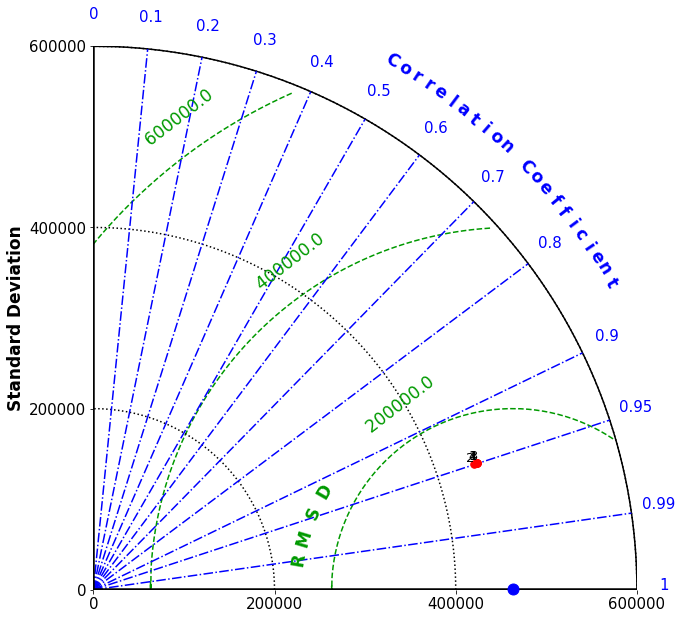

In [58]:
import skill_metrics as sm

for i in range(len(y_hats)):
  Yhat = y_hats[i]
  taylor_stats = sm.taylor_statistics(Yhat,y_test.to_numpy().ravel(),'data')

  sdev = np.array([taylor_stats['sdev'][0], taylor_stats['sdev'][1]])
  crmsd = np.array([taylor_stats['crmsd'][0], taylor_stats['crmsd'][1]])
  ccoef = np.array([taylor_stats['ccoef'][0], taylor_stats['ccoef'][1]])

  if i==0:
    plt.figure(figsize=(10,10))
    plt.rc('font', size=15)
    # taylor_diagram(STDs,RMSs,CORs,markerdisplayed='marker')
    sm.taylor_diagram(sdev, crmsd, ccoef, markerlabel=["Real",i+1], 
                      colOBS ='b', markercolor='red', markerobs = 'o', markersize=15)
  else:
    sm.taylor_diagram(sdev, crmsd, ccoef, markerlabel=["Real",i+1], 
                      colOBS ='b', markercolor='red', markerobs = 'o', markersize=15, overlay='on')

Podemos observar en el diagrama de Taylor que los modelos de Regresión Lineal, Ridge, Lasso y ElasticNet aportan valores muy similares entre ellos, casí igual desviación estandar, coeficiente de correlación y la raíz del error cuadrático medio.

# Conclusiones

Los tres modelos de regresión lineal ajustados son muy eficientes a la hora de predecir el precio total de los arriendos de departamentos en Santiago, pero también, estos modelos son muy parecidos entre si, y es que, si realizamos una revisión de las variables aleatorias de la muestra utilizadas para ajustarlos, podemos percatarnos que ninguna variable posee *outliers* que puedan afectar significativamente el plano, o tampoco contamos con una gran cantidad de variables que justifiquen los métodos de penalización como Ridge, Lasso o ElasticNet. Si bien, al comienzo de este trabajo limpiamos la base para eliminar los registros *outliers*, un futuro trabajo podría consistir en comparar los modelos actuales con la base sin *outliers* con modelos Ridge o Lasso considerando los *outliers*. Por lo tanto, si hay que escoger un modelo para ser utilizado en producción, el de regresón lineal sería suficiente, ley de la parsimonia. 

### Interpretación de los coeficientes

Al inicio de este trabajo se planteó como objetivo ver como influye en el precio de arriendo las característica enque poseen los departamentos en Santiago, según la oferta de PortalInmobiliario al día 13 de mayo, y tal como se ha señalado anteriormente, se opta por el uso del modelo de regresión lineal para dichas interpretaciones.

In [123]:
reg['regression'].intercept_

array([787136.55221052])

El intercepto, si bien no es un coeficiente tan direcatmente interpretable, se puede decir que el precio de arriendo de un departamento parte desde la base de los $787.136$ CLP

In [106]:
feature_names = reg[:-1].get_feature_names_out()
coefs = pd.DataFrame(
    reg['regression'].coef_.transpose(),
    columns=["Coefficients"],
    index=feature_names,
)
coefs = coefs.sort_values(by=['Coefficients'], ascending=False)

In [121]:
coefs.head(10)

,Coefficients
cat__comuna_RM (Metropolitana),499052.220560
cat__estacion_cercana_Observatorio,410512.106753
cat__comuna_San Bernardo,395852.108101
cat__estacion_cercana_Copa Lo Martínez,274611.243528
cat__estacion_cercana_La Granja,258658.828076
cat__estacion_cercana_Alcántara,243049.617348
cat__estacion_cercana_La Cisterna,236448.997422
cat__estacion_cercana_El Bosque,226408.045231
cat__estacion_cercana_El Golf,215379.767476
num__superficie_total,198555.929841


Luego de ordenar los coeficientes de mayor a menor, podemos observar que la precencia de la característica de la comuna RM (Metropolitana) es la que mayor aporta al precio del departamento con $499.052$ CLP, sin embargo, esta característica hace alusión a la región más que la comuna, esto se trataría de un error al momento de obtener los datos a partir del métodos *scraping*.

Luego, le sigue la presencia de la estación de metro cercana Observatorio con $410.521$ CLP, seguido de la comuna San Bernardo con $395.852$ CLP.

In [112]:
coefs.tail()

,Coefficients
cat__estacion_cercana_Cardenal Caro,-248231.953087
cat__estacion_cercana_Conchalí,-258102.376451
cat__comuna_Quilicura,-291541.478570
cat__estacion_cercana_Dorsal,-310151.008962
cat__estacion_cercana_Los Libertadores,-376985.426028


Las principales características que disminuyen el precio de arriendo de los departamentos son, la estación de metro cercana Los Libertadores disminuyendo el precio en $376.985$ CLP, estación Dorsal disminuyendo $310.151$ CLP y la comuna Quilicular disminuyendo $291.541$

In [119]:
coefs.loc[['num__dormitorios','num__baños','num__estacionamientos','num__bodegas','num__superficie_total','num__distancia_estacion']]

,Coefficients
num__dormitorios,14014.115728
num__baños,59995.486958
num__estacionamientos,46775.381491
num__bodegas,1939.596354
num__superficie_total,198555.929841
num__distancia_estacion,-5964.779727


Por otro lado, las variables númericas representan otra interpretabilidad interesante dentro del modelo, de este se observa que el aumento de 1 dormitorio en la vivienda aumenta el precio en $14.014$ CLP, añadir un baño aumenta el precio en $59.995$ CLP. El precio por metro cuadrado de la superficie total del departamto aumenta en $198.556$ CLP. Por cada metro que se aleja un departamento a una estación cercana disminuye su precio en $5.965$ CLP, osea, si un departamento se aleje 100 metro de una estación este provoca una disminución de $596.500$ CLP en el precio de arriendo

In [124]:
coefs.loc[['num__lat','num__long']]

,Coefficients
num__lat,155095.662570
num__long,26012.834139


La interpretación de la latitud y la longitud, si bien es fácil decir que el aúmento de una unidad de latitud aúmenta el precio en tanto, se deja para un siguiente trabajo en la que se pueda obtener información con interpretabilidad más cercana a la realidad con uso de unidad de medida en metros o kilometros, para ello se tiene presente el uso de la formula de Haversine

En conclusión, si bien el modelo ha aportado excelentes metricas de desempeño predictivo e información muy interesante para ver la influencia de las características de los departemento en el precio de arriendo de este, queda abierto para futuros trabajos: (1) mejorar las herramientas de muestreo (*scraping*) para datos no capturados, (2) aumentar la cantidad de registros a partir de nuevos muestreos en diferentes periodos, (3) agregar más características potencialmente relevantes, como por ejemplo, la cercanía a supermercado o farmacias, o indices de criminalidad. Todas estas mejoras son parte de desafios personales del investigador para más trabajos futuros y toda retroalimentación de esta es bienvenida.